# Main

In [1]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import train_test_split
import json

from gensim.models import Word2Vec
import string
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from utils import clean_text, text2words

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as torch_optim
import torch.nn.functional as F
import pandas as pd
from sklearn import metrics

from model import MODEL

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the data

In [2]:
df = pd.read_csv('movie_review_texts.csv')

In [3]:
df

,ID,note_text,class
0,12500,Bromwell High is a cartoon comedy. It ran at t...,1
1,12501,Homelessness (or Houselessness as George Carli...,1
2,12502,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,12503,This is easily the most underrated film inn th...,1
4,12504,This is not the typical Mel Brooks film. It wa...,1
...,...,...,...
24995,12495,"Towards the end of the movie, I felt it was to...",0
24996,12496,This is the kind of movie that my enemies cont...,0
24997,12497,I saw 'Descent' last night at the Stockholm Fi...,0
24998,12498,Some films that you pick up for a pound turn o...,0


In [4]:
df = df.loc[~df.note_text.isnull()]

In [5]:
df

,ID,note_text,class
0,12500,Bromwell High is a cartoon comedy. It ran at t...,1
1,12501,Homelessness (or Houselessness as George Carli...,1
2,12502,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,12503,This is easily the most underrated film inn th...,1
4,12504,This is not the typical Mel Brooks film. It wa...,1
...,...,...,...
24995,12495,"Towards the end of the movie, I felt it was to...",0
24996,12496,This is the kind of movie that my enemies cont...,0
24997,12497,I saw 'Descent' last night at the Stockholm Fi...,0
24998,12498,Some films that you pick up for a pound turn o...,0


In [6]:
df = df.rename(columns={'class':'target'})

## Clean the text

In [7]:
df['cleaned'] = df.note_text.apply(lambda x: clean_text(x))
df['text'] = df.cleaned.str.split(r'\s+')

### Output the targets as JSON

In [8]:
target_dict = {}
for idx, row in df[['ID', 'target']].drop_duplicates().iterrows():
    target_dict[str(row['ID'])] = str(row['target'])
json.dump(target_dict, open('./target_dict.json', 'w'))


## Make the train/valid/test splits

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[['ID', 'note_text', 'cleaned', 'text']], df[['ID', 'target']], test_size=0.2, random_state=1)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.25, random_state=1)

In [11]:
X_train

,ID,note_text,cleaned,text
12458,24958,Just get it. The DVD is cheap and easy to come...,just get it the dvd is cheap and easy to come ...,"[just, get, it, the, dvd, is, cheap, and, easy..."
4972,17472,"When I rented this movie to watch it, I knew t...",when i rented this movie to watch it i knew th...,"[when, i, rented, this, movie, to, watch, it, ..."
13055,555,En route to a small town that lays way off the...,en route to a small town that lays way off the...,"[en, route, to, a, small, town, that, lays, wa..."
210,12710,"The Movie was sub-par, but this Television Pil...",the movie was sub par but this television pilo...,"[the, movie, was, sub, par, but, this, televis..."
9844,22344,Only seen season 1 so far but this is just gre...,only seen season 0 so far but this is just gre...,"[only, seen, season, 0, so, far, but, this, is..."
...,...,...,...,...
18597,6097,This movie is awful. At the end of it you will...,this movie is awful at the end of it you will ...,"[this, movie, is, awful, at, the, end, of, it,..."
14652,2152,The movie began well enough. It had a fellow g...,the movie began well enough it had a fellow ge...,"[the, movie, began, well, enough, it, had, a, ..."
2687,15187,I love this movie like no other. Another time ...,i love this movie like no other another time i...,"[i, love, this, movie, like, no, other, anothe..."
22318,9818,A warning to potential viewers: if you are loo...,a warning to potential viewers if you are look...,"[a, warning, to, potential, viewers, if, you, ..."


<AxesSubplot:>

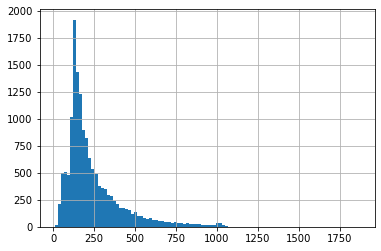

In [12]:
X_train.text.str.len().hist(bins=100)

## Run the Word2Vec Model

In [13]:
vector_size = 50
num_words = 250

In [14]:
def word2vec_model(texts, vector_size=50):
    
    print('Running the Word2Vec Model...\n\n')
    
    model = Word2Vec(sentences=texts, size=vector_size, min_count=1)
    
    return model

In [15]:
model = word2vec_model(X_train.text.tolist(), vector_size)

Running the Word2Vec Model...




In [16]:
y_train

,ID,target
12458,24958,1
4972,17472,1
13055,555,0
210,12710,1
9844,22344,1
...,...,...
18597,6097,0
14652,2152,0
2687,15187,1
22318,9818,0


In [17]:
my_dict = dict({})
for idx, key in enumerate(model.wv.vocab):
    my_dict[key] = model.wv[key]

## Dataset Class

In [18]:
class DataBowl(Dataset):
    def __init__(self, X, y, ids, vector_size, my_dict, num_words, phase='train'):
        assert (phase == 'train' or phase == 'valid' or phase == 'test')
        self.phase = phase
        self.X = X
        self.y = y
        self.ids = ids
        self.vector_size = vector_size
        self.my_dict = my_dict
        self.num_words = num_words

    def get_mm_item(self, idx):

        pid = self.ids.iloc[idx]
        label = np.array([int(l)
                          for l in self.y.loc[self.y.ID==pid].target], dtype=np.float32)        

        content = [my_dict.get(k, np.zeros(50,dtype=float)) for k in self.X.loc[self.X.ID==pid]['text']\
                   .iloc[0][-self.num_words:]]
        
        if len(content) < self.num_words:
            y = self.num_words-len(content)
            add_ = []
            for j in range(y):
                add_.append([0]*self.vector_size)

            add_.extend(content)
            content = add_
        else:
            content = content[-self.num_words:]
        
        content = np.array(content, dtype=np.float32)

        return torch.from_numpy(content), torch.from_numpy(label), pid

    def __getitem__(self, idx):
        return self.get_mm_item(idx)

    def __len__(self):
        return len(self.ids)

## Initiate the data sets

In [19]:
train_ds = DataBowl(X_train, y_train, X_train.ID, vector_size, my_dict, num_words, phase='train')
valid_ds = DataBowl(X_valid, y_valid, X_valid.ID, vector_size, my_dict, num_words, phase='valid')
test_ds = DataBowl(X_test, y_test, X_test.ID, vector_size, my_dict, num_words, phase='test')

In [20]:
y_train

,ID,target
12458,24958,1
4972,17472,1
13055,555,0
210,12710,1
9844,22344,1
...,...,...
18597,6097,0
14652,2152,0
2687,15187,1
22318,9818,0


## Support Functions

In [21]:
def save_model(p_dict):
    model = p_dict['model']
    state_dict = model.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].cpu()
    all_dict = {
            'best_metric': p_dict['best_metric'],
            'state_dict': state_dict 
            }
    torch.save(all_dict, 'best_model.ckpt')

In [22]:
def load_model(p_dict):
    all_dict = torch.load('best_model.ckpt')
    p_dict['best_metric'] = all_dict['best_metric']
    p_dict['model'].load_state_dict(all_dict['state_dict'])

## Train the model

In [23]:
model = MODEL({'K':20})

parameters_all = []
for p in model.parameters():
    parameters_all.append(p)

optimizer = torch.optim.Adam(parameters_all)

loss = F.binary_cross_entropy

def train_eval(data_loader, optimizer, loss, phase, saliency=False, best_metric=0, optimal_threshold=0):
    
#     for e in range(epochs):
        
    if saliency:
        model.eval()
        
        df = pd.DataFrame(columns=range(20))
        
    else: 
        if phase == 'train':
            model.train()
        else:
            model.eval()
    
    loss_list, pred_list, label_list, = [], [], []

    for b, data_list in enumerate(data_loader):
        content, label, patients = data_list
        
        content = content.view(content.shape[0],1,num_words,vector_size)
        output_global, output_local, output_saliency = model(content)

        
        if saliency:
            
            temp_df = pd.DataFrame(index=patients.numpy(), columns=range(20))
            for iii in range(len(patients)):
                temp_saliency = [i.item() for i in output_saliency[iii,:,0]]
                temp_df.loc[patients[iii].item()] = temp_saliency

            df = df.append(temp_df)
            
            df.to_csv('saliency_results_'+phase+'.csv')
                
        else:
            
            if phase=='train':
                    
                loss_output = 2*loss(output_local, label)+loss(output_global, label)

                optimizer.zero_grad()
                loss_output.backward()
                optimizer.step()

            elif phase=='valid':

                loss_output = 2*loss(output_local, label)+loss(output_global,label)

            elif phase=='test':

                loss_output = 2*loss(output_local, label)+loss(output_global,label)

            output = output_local

            pred_list.append(output.data.cpu().numpy())
            loss_list.append(loss_output.data.cpu().numpy())
            label_list.append(label.data.cpu().numpy())

    if saliency==False:
    
        if phase=='valid':

            label_list = [jj[0] for jj in label_list]
            pred_list = [jj[0] for jj in label_list]

            # Calculate the AUC

            fpr, tpr, thresholds = metrics.roc_curve(label_list, pred_list)
            auc = metrics.auc(fpr, tpr)

            # Calculate the optimal threshold by f1 score
            preds = [1 if prob >= thresholds[0] else 0 for prob in pred_list]
            f1 = metrics.f1_score(label_list, preds)

            for t in thresholds[1:]:
                preds = [1 if prob >= t else 0 for prob in pred_list]
                temp_f1 = metrics.f1_score(label_list, preds)
                if temp_f1 > f1:
                    optimal_threshold = t
                    f1 = temp_f1
            preds = [1 if prob >= optimal_threshold else 0 for prob in pred_list]
            tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds).ravel()
            precision = 1.0 * (tp / (tp + fp))
            sen = 1.0 * (tp / (tp + fn))
            spec = 1.0 * (tn / (tn + fp))
            f1 = metrics.f1_score(label_list, preds)

            print('Validation AUC: {:}\n'.format(auc))
            print('Validation Precision: {:}\n'.format(precision))
            print('Validation Sensitivity: {:}\n'.format(sen))
            print('Validation Specificity: {:}\n'.format(spec))
            print('Validation F1: {:}\n'.format(f1))

            if f1>best_metric:
                best_metric = f1
                save_model({'model': model, 'best_metric': best_metric})
                print('Saving the model')
            return best_metric, optimal_threshold


        elif phase=='test':
            label_list = [jj[0] for jj in label_list]
            pred_list = [jj[0] for jj in label_list]

            # Calculate the AUC
            fpr, tpr, thresholds = metrics.roc_curve(label_list, pred_list)
            auc = metrics.auc(fpr, tpr)

            # Calculate the optimal threshold by f1 score

            preds = [1 if prob >= optimal_threshold else 0 for prob in pred_list]
            tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds).ravel()
            precision = 1.0 * (tp / (tp + fp))
            sen = 1.0 * (tp / (tp + fn))
            spec = 1.0 * (tn / (tn + fp))
            f1 = metrics.f1_score(label_list, preds)

            print('Test AUC: {:}\n'.format(auc))
            print('Test Precision: {:}\n'.format(precision))
            print('Test Sensitivity: {:}\n'.format(sen))
            print('Test Specificity: {:}\n'.format(spec))
            print('Test F1: {:}\n'.format(f1))

            return auc, precision, sen, spec, f1
        

### Train the model

In [24]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

In [25]:
epochs = 20
best_metric = 0

for i in range(epochs):
    print('\n\n#################\n\nEpoch: '+str(i)+'\n\n#################\n')
    train_eval(train_loader, optimizer, loss, 'train')
    best_metric,optimal_threshold = train_eval(valid_loader, optimizer, loss, 'valid', best_metric=best_metric)
    train_eval(test_loader, optimizer, loss, 'test', best_metric=best_metric, optimal_threshold=optimal_threshold)



#################

Epoch: 0

#################

Validation AUC: 1.0

Validation Precision: 1.0

Validation Sensitivity: 1.0

Validation Specificity: 1.0

Validation F1: 1.0

Saving the model
[array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=floa

KeyboardInterrupt: 

## Extract Local Texts

### Just take a random sample for the saliency

In [26]:
train_ids = random.sample(X_train.ID.tolist(), 100)
test_ids = random.sample(X_test.ID.tolist(),100)

train_ds_sal = DataBowl(X_train.loc[X_train.ID.isin(train_ids)], \
                        y_train.loc[y_train.ID.isin(train_ids)], pd.Series(train_ids), vector_size, my_dict, num_words, phase='train')
test_ds_sal = DataBowl(X_test.loc[X_test.ID.isin(test_ids)], \
                       y_test.loc[y_test.ID.isin(test_ids)], pd.Series(test_ids), vector_size, my_dict, num_words, phase='test')
                                    

In [27]:
train_loader_saliency = DataLoader(train_ds_sal, batch_size=1)
test_loader_saliency  = DataLoader(test_ds_sal, batch_size=1)

In [28]:
train_eval(train_loader_saliency, optimizer, loss, 'train', saliency=True)

In [29]:
train_eval(test_loader_saliency, optimizer, loss, 'test', saliency=True)

## Analyze the saliency texts

In [30]:
sal_train = pd.read_csv('saliency_results_train.csv').rename(columns={'Unnamed: 0':'ID'}).set_index('ID')

In [31]:
sal_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ID,,,,,,,,,,,,,,,,,,,,
15356,59,170,215,9,73,192,232,46,157,122,134,33,96,111,147,181,86,22,203,0
10754,177,212,121,135,189,154,224,234,109,199,0,10,20,30,40,50,60,70,80,90
8565,3,235,92,23,151,59,169,129,220,106,189,36,80,205,46,116,179,69,140,13
6330,59,35,185,146,133,224,19,173,199,2,71,104,88,211,236,47,158,119,78,9
18100,177,8,237,165,118,29,202,135,52,64,79,225,103,188,148,213,91,42,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9027,180,42,203,63,78,99,139,114,221,14,155,233,125,29,2,168,190,88,53,211
628,236,169,218,148,200,185,0,10,20,30,40,50,60,70,80,90,100,110,120,130
10192,208,144,39,161,99,182,23,1,64,111,53,87,123,228,134,11,195,240,76,172


## Print local texts

In [32]:
id1 = sal_train.index[0]

temp_note = df.loc[df.ID==id1]['text'].iloc[0]

if len(temp_note)<num_words:
    print(len(temp_note))
    ddiff = num_words-len(temp_note)
    buffer = ['' for i in range(ddiff)]
    buffer.extend(temp_note)
    
    temp_note = buffer
    
    
print(df.loc[df.ID==id1].target.iloc[0])
    
for ii in sal_train.loc[id1]:
    print(' '.join(temp_note[ii-5:ii+15]))
    

1
always admitting his findings were accurate flash forward to 0 several months prior to september 0 th a book entitled
clear herself of the lies over the time frame of 0 minutes the film attempts to reveal is norma khouri
including an ex husband her publisher and others tell their side of the story this is a toothsome well produced
mid 0 s clifford irving proposed to write the ultimate biography of howard hughes claiming to have spent months preparing
september 0 th a book entitled forbidden love published in the u s as honor lostlove and death in modern
truth or is she just a compulsive liar with an agenda vendetta of her own interview footage with those who
toothsome well produced documentary that manages to point many fingers at just as many potential guilty parties not rated but
be false irving was accused of perjury spent several years behind bars although always admitting his findings were accurate flash
broinowski attempts to delve into the quagmire that was khouri s attempts t

In [33]:
sal_test = pd.read_csv('saliency_results_test.csv').rename(columns={'Unnamed: 0':'ID'}).set_index('ID')

In [34]:
id1 = sal_test.index[0]

temp_note = df.loc[df.ID==id1]['text'].iloc[0]

if len(temp_note)<num_words:
    print(len(temp_note))
    ddiff = num_words-len(temp_note)
    buffer = ['' for i in range(ddiff)]
    buffer.extend(temp_note)
    
    temp_note = buffer
    
    
print(df.loc[df.ID==id1].target.iloc[0])
    
for ii in sal_test.loc[id1]:
    print(' '.join(temp_note[ii-5:ii+15]))
    

111
0
 i watched this show and i simply didn t find it funny at all it might have been the
as a station all the characters on this show are pretty bad actors but even if they were good the
they are playing they might just keep this one simply because it s average compared to them
good the jokes and script are pretty horrible and would still bring the show down i would say that i
the show down i would say that i believe this show will be cancelled but seeing as how abc is
at all it might have been the first episode lately i realize abc is playing a lot of stupid shows
be cancelled but seeing as how abc is doing pretty horrible for quality of shows they are playing they might
is playing a lot of stupid shows nowadays and is going down as a station all the characters on this
               i watched this show and

                   
                   
                   
                   
                   
                   
                   
                   
                 